# Futures and Forward Rate Agreements

This notebook explores the structure of interest rate futures and forward rate agreements (FRAs). We will take a look at mark-to-market gains and losses, risk and an FRA's convexity relative to futures.

In [1]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Futures price

Generally, interest rate futures are subject to daily mark-to-market payments. Let's say we have an interest rate future based on a market reference rate (MRR). At time $t=0$ we purchase the futures contract, which implies that we pay the futures price

$$ P_{futures} = 100 - (100 * MRR_{A, B-A}), $$

where time $t=A$ is the time to expiration of the contract, and $B-A$ is the time corresponding to the MRR. For instance, if the expiration is in 2 months and the MRR is a six month rate, we are interested in the forward rate $MRR_{2m, 6m}$. 

As this reference rate changes, the price of the futures contract changes. Below we show this. Note that the first subscript in the MRR is subject to change as we progress through the days. Indeed, after one day we are not looking at $MRR_{2m, 6m}$ anymore, but at $MRR_{1m30d, 6m}$, if the current month has 31 days. 

In [2]:
time_to_expiration = 2/12       # this relates to the time until the contract expires (the 2m in our example)
time_in_contract = 6/12         # this relates to the time associated with the market reference rate (the 6m in our example)
notional = 10_000_000           # the notional principal in the contract

time_in_days = [0, 1, 2, 3, 4, 5]
mrr = [0.055, 0.0548, 0.0547, 0.0547, 0.0548, 0.0547]       # annualized market reference rate

futures_df = pd.DataFrame()
futures_df['time (days)'] = time_in_days
futures_df['MRR'] = mrr
futures_df['price'] = 100 - 100*futures_df['MRR']*time_in_contract

futures_df

,time (days),MRR,price
0,0,0.0550,97.250
1,1,0.0548,97.260
2,2,0.0547,97.265
3,3,0.0547,97.265
4,4,0.0548,97.260
5,5,0.0547,97.265


### Valuing our position

The contract we specified has a notional. From the notional and the futures price, we can first specify the cost of entering the contract, which is the price at $t=0$ times the notional. Subsequently, we can track the market value of our position over the days that follow. 

At $t=1$, the reference rate decreases 2 basis points (bps) to 2.48%. The futures price resulting from that change in the MRR, is 97.52. This means that our position has gained value. 

In [3]:
# include the value of our position
cost_at_initiation = futures_df['price'].loc[0] / 100 * notional
futures_df['notional'] = notional
futures_df['value of position'] = notional * futures_df['price'] / 100

### Mark-to-Market gains/losses

So, after day 1 we daily mark-to-market (MtM) payments suggest that we should get our margin account credited by the increase in value. The party that sold us the futures contract is the one crediting our account with the margin payment. 

After, the settlement price of the futures contract resets to the current futures price. We then wait another day and see how much the MtM value has changed relative to the latest settlement price, and another margin payment is exchanged after day 2. 

In [4]:
# equating the settlement price of the contract to the EOD futures price (on which the margin payments are based)
futures_df['settlement price'] = notional * futures_df['price'] / 100  

# determining the MtM from time i-1 to i based on our previous settlement price and the current value of our position/settlement price
futures_df['MtM'] = futures_df['value of position'] - futures_df['settlement price'].shift(1)
futures_df.loc[0, 'MtM'] = 0.0      # the first MtM will be NaN with above, but at t=0 it should be zero.


In [5]:
futures_df

,time (days),MRR,price,notional,value of position,settlement price,MtM
0,0,0.0550,97.250,10000000,9725000.0,9725000.0,0.0
1,1,0.0548,97.260,10000000,9726000.0,9726000.0,1000.0
2,2,0.0547,97.265,10000000,9726500.0,9726500.0,500.0
3,3,0.0547,97.265,10000000,9726500.0,9726500.0,0.0
4,4,0.0548,97.260,10000000,9726000.0,9726000.0,-500.0
5,5,0.0547,97.265,10000000,9726500.0,9726500.0,500.0


### Risk

As we observe from the MtM payments, a decrease of the MRR with 2 bps relates to an increase in price of 1 cent. This is because the MRR is quoted on an annual basis. The value of the position changes proportionally to the notional, the time in the contract and the change in the MRR. Specifically, we can express the risk as the basis point value

$$ BPV = notional \times period \times 0.01\% $$

Below, we see that this value directly relates to the MtM changes in our example. 

In [6]:
# interest rate risk (basis point value)
bpv = notional * time_in_contract * 0.0001 
bpv

500.0

### Graphical representation

If we graph the futures price as a function of the MRR, we can see that the relation is linear. Precisely as we expected by the way the futures price is constructed (linearly in the MRR). 

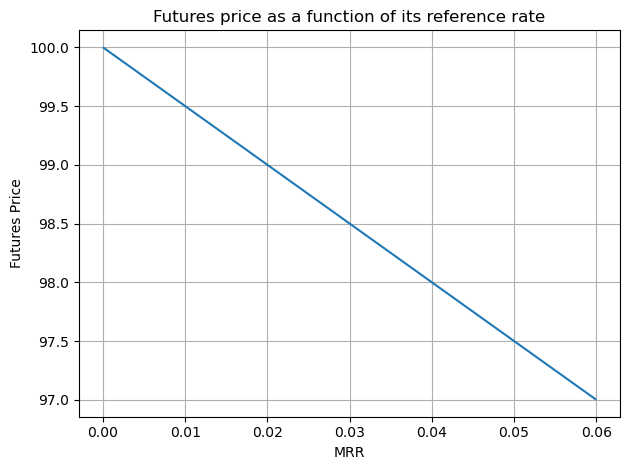

In [7]:
mrr_list = np.arange(start=0.0001, stop=0.0600, step=0.0001)
futures_price_list = 100 - 100*mrr_list*time_in_contract 

plt.figure()                 
plt.plot(mrr_list, futures_price_list)

# Labels & title
plt.title("Futures price as a function of its reference rate")   # plot title
plt.xlabel("MRR")                                                # x-axis label
plt.ylabel("Futures Price")                                      # y-axis label

plt.grid(True)                # optional: add a grid
plt.tight_layout()            # tidy spacing
plt.show()

## Forward Rate Agreements

A Forward Rate Agreement is similar to an interest rate future. Both concern a derivative, which derives it's value from a market reference rate (MRR). Assume we have an FRA starting in 2m for a period of 6m, similar to our futures example. The key differences are:

- The futures contract is quoted on a price basis where the FRA is quoted on a rate basis
- The futures contract has daily mark-to-market payments, mostly FRAs don't 
- Futures contracts are traded cleared on an exchange, FRAs are mostly OTC
- Futures and FRA settlement and cashflows are different.

Let me explain the last bullet below.

The futures price is solely a linear function of the MRR. A change of 1 bps in the MRR results in a proportional change in the of the futures position by the BPV. Each day cashflows are exchanged, but cumulative, the cashflows exchanged at expiration are really just the change in MRR between entering the contract and the MRR at the day of expiration. 

This means, no actual interest is paid. Moreover, as the position moves in your favour, MtM payments made by the counterparty may be drawn from the margin account and can be invested to earn interest. 

The FRA has a different structure. At expiration (same date as in the futures contract) the MRR determines the interest paid on the notional over the period corresponding to the MRR. So, in this case, an actual interest payment is made (see figure below). 

The result is that changes in the MRR impact the value of the futures position differently than the value of an identical position in an FRA. Let's dive into these differences.

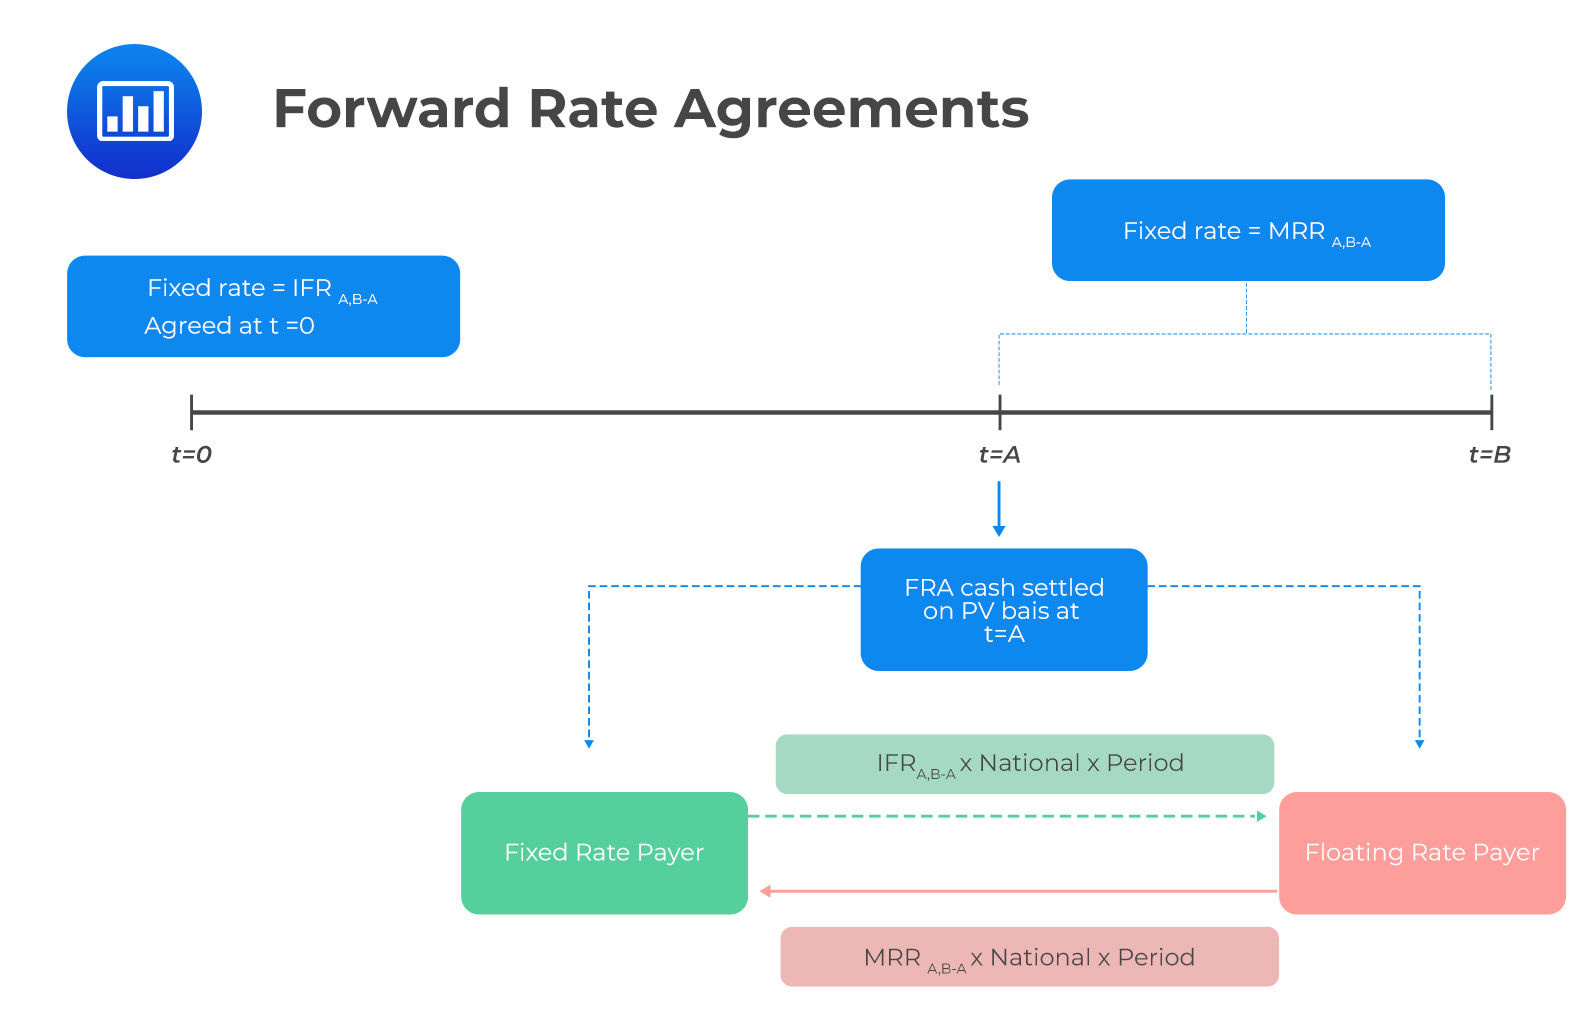


### FRA payments

Ok, let us retrieve our example of the 2m6m FRA. Assume the 2m6m MRR is 2.5% right now at t=0, just like we assumed in the futures contract. Two months from now the 6m MRR will generally have a value different than right now. Our eventual payoff is determined by this so-called realised MRR. However, right now we have a fair value given current rates that equates the value of the FRA to zero. 

Note that this in practice would be the implied forward rate between a 2m MRR and 8m MRR if available. Assume we also have a 2m MRR (equal to 1.8%) such that we can express the forward rate in terms of the 2m and 8m MRR (2.33%):

$$ (1 + MRR_{2m} * 2/12) * (1 + FRA_{2m6m}*6/12) = (1 + MRR_{8m}*8/12) $$

In [8]:
# the rate for 8m MRR (not annualised)
mrr_8m = ((1 + 0.018 * 2/12) * (1 + 0.025 * 6/12) - 1) * 12/8
mrr_8m

0.02330624999999964

Upon expiry of the contract, we will know all variables that make up the payment at a realised basis. At initiation of the FRA, we know the FRA fixed rate for which the expected present value of the fixed payment is equal to that of the floating payment based on the future 6m MRR. At expiry we also know the variable rate, the 6m MRR, and assume we have at $t=2/12$, $MRR_{6m} = 0.068872$. 

In [ ]:
fixed_rate_FRA = 0.055
mrr_6m_realised = 0.06887240868665596

fixed_payment = fixed_rate_FRA * notional * time_in_contract
float_payment = mrr_6m_realised * notional * time_in_contract

# payoff at expiration (assumes fixed rate payer)
net_payment = fixed_payment - float_payment
net_payment

69362.04343327985

However, this is not the actual payment made. Because at expiration the net payment relates to a payment at $t=8/12$ since the interest is paid over the period from 2m to 8m from $t=0$. This means that we should discount the net payment at the appropriate market rate (the 6m MRR at $t=2$). This results a cashflow at $t=2$ for the fixed-rate receiver of

$$ cashflow = (fixed - float) \times \left( \frac{1}{1 + MRR_{6m} * 6/12}\right) $$



In [ ]:
payoff_fra = (fixed_payment - float_payment) * (1 / (1 + mrr_6m_realised * 6/12))

# or equivalently, just taking the contract fixed rate and realised MRR alongside the notional
payoff_fra = notional * ((fixed_rate_FRA - mrr_6m_realised) * 6/12) * (1 / (1 + mrr_6m_realised * 6/12))
payoff_fra

67052.99286901085

### Comparing Futures payoff versus FRA payoff

Assume (for now) that there are no daily MtM payments in the futures contract. That is, we isolate the payment that would result in the futures contract from the pure deviation of the 6m MRR at $t=2$ from its implied value at $t=0$. 

Just like in the FRA example, we will take the same 6m MRR (6.89%). The payout would be (anologous to the first futures example)

In [11]:
price_t0 = 100 - (100 * fixed_rate_FRA * time_in_contract)
price_expiration = 100 - (100 * mrr_6m_realised * time_in_contract)

print(f"At initiation, the MRR was {100 * fixed_rate_FRA}% which resulted in a futures price of {price_t0}")
print(f"At expiry, the MRR was {round(100 * mrr_6m_realised, 3)}% which resulted in a futures price of {round(price_expiration, 2)}")

At initiation, the MRR was 5.5% which resulted in a futures price of 97.25
At expiry, the MRR was 6.887% which resulted in a futures price of 96.56


In [13]:
# payoff
payoff_future = (price_expiration - price_t0) / 100 * notional
payoff_future

-69362.04343328

In [14]:
print(f"The payoff of the FRA:          {round(payoff_fra, 2)}")
print(f"The payoff of the future:       {round(payoff_future, 2)}")

The payoff of the FRA:          67052.99
The payoff of the future:       -69362.04


### Define difference in payout through convexity

As the payoff in the FRA relates to a payment of interest which is paid up front for the 6m period corresponding to the MRR, we discount this payment from 6m into the future, to now. Consequently, a upwards change in the interest rate, means heavier discounting of the cash flow than when the MRR has decreased. 

So, if you receive fixed, it means that if the MRR is actually higher than your fixed rate at expiry, you have to pay the counterparty the difference. But, it is discounted against the higher rate. When the MRR is lower at expiration, you gain the money difference of the higher fixed rate, and the cashflow is discounted less than at your fixed rate. This feature is called convexity (since the payout curve as a function of the MRR is convex). For futures this payoff is really just a straight line. Let's take a look:

In [100]:
mrr_list_convexity = np.arange(start=0.0001, stop=(fixed_rate_FRA*2), step=0.0001)


convexity_df = pd.DataFrame()
convexity_df['MRR'] = mrr_list_convexity
convexity_df['Futures Payoff per 100EUR'] = price_t0 - ( 100 - (100 * convexity_df['MRR'] * time_in_contract) )
convexity_df['FRA Payoff per 100EUR'] = - 100 * (fixed_rate_FRA - convexity_df['MRR']) * time_in_contract * (1/ (1 + convexity_df['MRR']*time_in_contract))

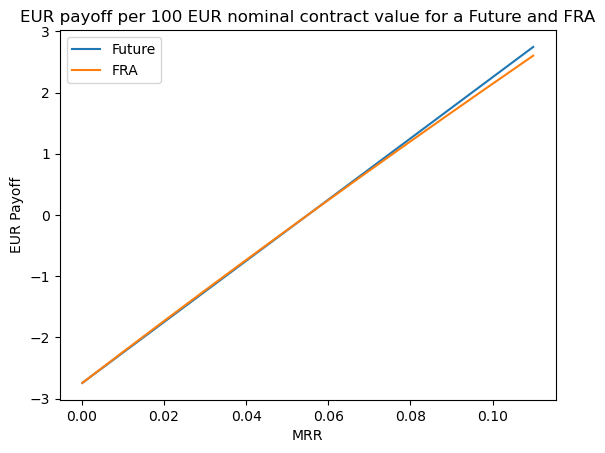

In [101]:
plt.plot(convexity_df['MRR'], convexity_df['Futures Payoff per 100EUR'], label='Future')
plt.plot(convexity_df['MRR'], convexity_df['FRA Payoff per 100EUR'], label='FRA')

plt.title("EUR payoff per 100 EUR nominal contract value for a Future and FRA")
plt.xlabel("MRR")
plt.ylabel("EUR Payoff")
plt.legend()
plt.show()

Let's zoom in a bit at the higher MRRs since there the differences get really visible. Close to zero, the discounting becomes less pronounced given the low rate. As is shown in the graph below, for higher rates, we can really see the difference. And this is for 100EUR notional and a 6m period. A larger contract size and longer tenor both also increase the difference. 

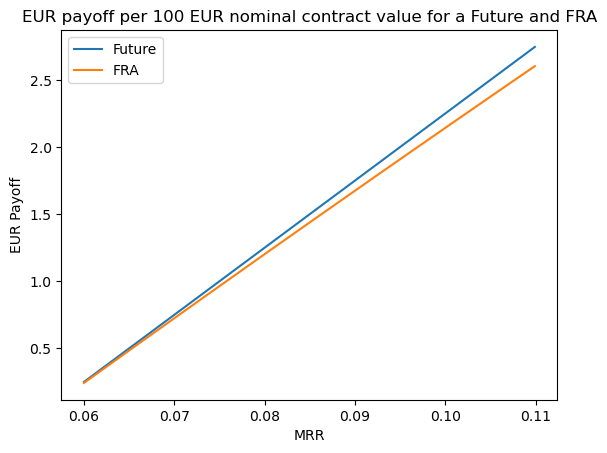

In [102]:
plt.plot(convexity_df[convexity_df['MRR'] > 0.06]['MRR'], convexity_df[convexity_df['MRR'] > 0.06]['Futures Payoff per 100EUR'], label='Future')
plt.plot(convexity_df[convexity_df['MRR'] > 0.06]['MRR'], convexity_df[convexity_df['MRR'] > 0.06]['FRA Payoff per 100EUR'], label='FRA')

plt.title("EUR payoff per 100 EUR nominal contract value for a Future and FRA")
plt.xlabel("MRR")
plt.ylabel("EUR Payoff")
plt.legend()
plt.show()

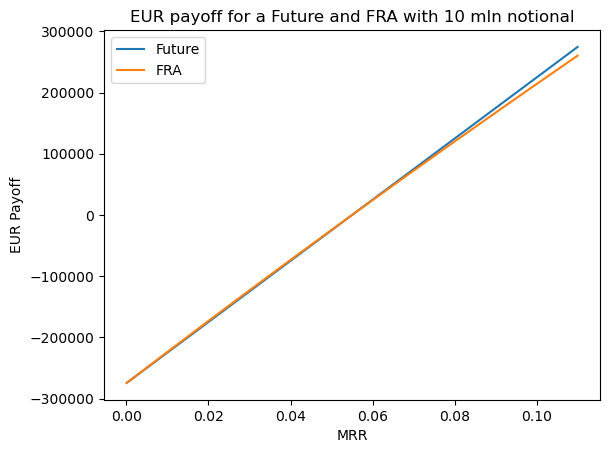

In [103]:
convexity_df['Futures Payoff contract'] = (price_t0 - ( 100 - (100 * convexity_df['MRR'] * time_in_contract) )) / 100 * notional
convexity_df['FRA Payoff contract'] = - notional * (fixed_rate_FRA - convexity_df['MRR']) * time_in_contract * (1/ (1 + convexity_df['MRR']*time_in_contract))

plt.plot(convexity_df['MRR'], convexity_df['Futures Payoff contract'], label='Future')
plt.plot(convexity_df['MRR'], convexity_df['FRA Payoff contract'], label='FRA')

plt.title("EUR payoff for a Future and FRA with 10 mln notional")
plt.xlabel("MRR")
plt.ylabel("EUR Payoff")
plt.legend()
plt.show()

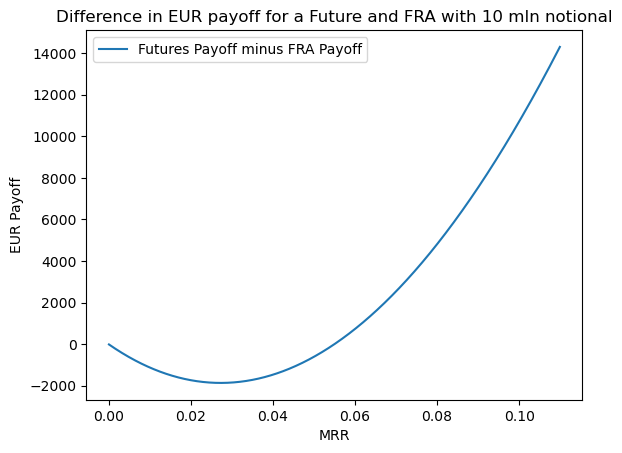

In [104]:
convexity_df['difference contract'] = convexity_df['Futures Payoff contract'] - convexity_df['FRA Payoff contract']
plt.plot(convexity_df['MRR'], convexity_df['difference contract'], label='Futures Payoff minus FRA Payoff')

plt.title("Difference in EUR payoff for a Future and FRA with 10 mln notional")
plt.xlabel("MRR")
plt.ylabel("EUR Payoff")
plt.legend()
plt.show()

Now consider the futures payoff given the realised daily implied forward MRR rates. 

In [42]:
seed = 24

kappa = 0.8
T = 6/12
mu = 0.055
r_0 = mu
sigma = 0.02

nSteps = 30*6           # 180 days
nSimulations = 1        # just need one path for now

In [43]:
def getSimulatedRatePath(kappa, mu, sigma, r_0, nSimulations, nSteps, T, seed):
    np.random.seed(seed)
    delta = T / nSteps    # step length
    varSR = sigma**2 * (1 - np.exp( -2 * kappa * delta )) / (2*kappa) # short-rate variance

    ratePaths = np.zeros([nSimulations, nSteps])

    for i in range(nSimulations):

        # initiate path from r_0
        ratePaths[i, 0] = r_0 

        for t in range(1, nSteps):
            # generate disturbance
            z_td = np.random.normal(0, np.sqrt(varSR))

            # closed-form solution for r_{t+d}
            ratePaths[i, t] = np.exp( - kappa * delta ) * ratePaths[i, (t-1)] + (1 - np.exp( - kappa * delta )) * mu + z_td


    return ratePaths

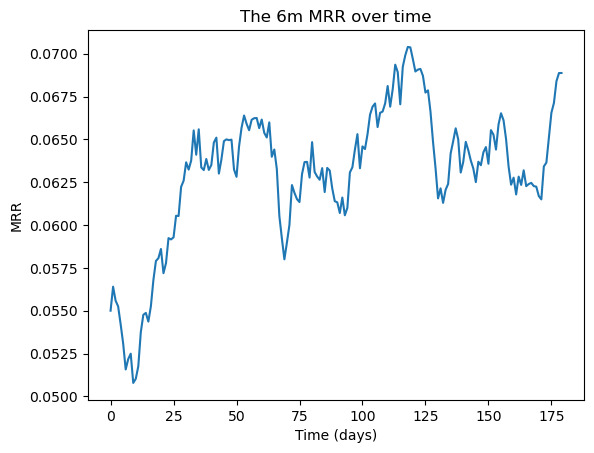

In [44]:
rate_path = getSimulatedRatePath(kappa, mu, sigma, r_0, nSimulations, nSteps, T, seed)

plt.figure()
plt.plot(rate_path[0, :])

plt.title("The 6m MRR over time")
plt.xlabel("Time (days)")
plt.ylabel("MRR")

plt.show()

Take a good look at the chart, our realised 6m MRR was not coincidental. It relates to the last value in our simulated rate path for the 6m MRR. 

In [45]:
rate_path[0, -1]

0.06887240868665596

But now, with the daily MRR values we can construct the margin payments, and daily MtMs just like we did in our micro example 6 days into the future.

In [51]:
days = np.arange(start=0, stop=180, step=1)
mrr_path = rate_path[0, :]

futures_df = pd.DataFrame()
futures_df['days'] = days
futures_df['MRR'] = mrr_path
futures_df

,days,MRR
0,0,0.055000
1,1,0.056400
2,2,0.055586
3,3,0.055251
4,4,0.054208
...,...,...
175,175,0.066555
176,176,0.067123
177,177,0.068390
178,178,0.068869


Let's rebuild our MtM values just like before:

In [ ]:
futures_df['price'] = 100 - 100*futures_df['MRR']*time_in_contract
futures_df['notional'] = notional
futures_df['value of position'] = notional * futures_df['price'] / 100
futures_df['MtM'] = futures_df['value of position'] - futures_df['value of position'].shift(1)
futures_df.loc[0, 'MtM'] = 0.0      # the first MtM will be NaN with above, but at t=0 it should be zero.

,days,MRR,price,notional,value of position,MtM
0,0,0.055000,97.250000,10000000,9.725000e+06,0.000000
1,1,0.056400,97.180022,10000000,9.718002e+06,-6997.786509
2,2,0.055586,97.220717,10000000,9.722072e+06,4069.460812
3,3,0.055251,97.237433,10000000,9.723743e+06,1671.593579
4,4,0.054208,97.289623,10000000,9.728962e+06,5219.022003
...,...,...,...,...,...,...
175,175,0.066555,96.672231,10000000,9.667223e+06,-7364.225845
176,176,0.067123,96.643842,10000000,9.664384e+06,-2838.910822
177,177,0.068390,96.580525,10000000,9.658052e+06,-6331.684480
178,178,0.068869,96.556546,10000000,9.655655e+06,-2397.851671


In [54]:
# total nominal exchanges of cash up to expiration
futures_df['MtM'].sum()

# let's keep track of our margin account
futures_df['margin account value'] = futures_df['MtM'].cumsum()
futures_df

,days,MRR,price,notional,value of position,MtM,margin account value
0,0,0.055000,97.250000,10000000,9.725000e+06,0.000000,0.000000
1,1,0.056400,97.180022,10000000,9.718002e+06,-6997.786509,-6997.786509
2,2,0.055586,97.220717,10000000,9.722072e+06,4069.460812,-2928.325697
3,3,0.055251,97.237433,10000000,9.723743e+06,1671.593579,-1256.732118
4,4,0.054208,97.289623,10000000,9.728962e+06,5219.022003,3962.289885
...,...,...,...,...,...,...,...
175,175,0.066555,96.672231,10000000,9.667223e+06,-7364.225845,-57776.905058
176,176,0.067123,96.643842,10000000,9.664384e+06,-2838.910822,-60615.815881
177,177,0.068390,96.580525,10000000,9.658052e+06,-6331.684480,-66947.500361
178,178,0.068869,96.556546,10000000,9.655655e+06,-2397.851671,-69345.352032


Keeping track of the margin account value is not entirely just for fun, it serves a purpose. In FRAs there is no exchange of cash between initiation of the contract, and expiration. This results in just one cashflow, which we computed above for the realised 6m MRR. 

The futures contract has daily settlements, which results in interest accrual during the contract over the margin account. Or, when the margin account value is negative (and thus payments should be made to the counterparty) interest on that amount is paid. 

So let us assume for real simplicity that there is just one constant o/n rate $r_{o/n} = 0.05$. 

In [57]:
r_on = 0.05
futures_df['interest received'] = futures_df['margin account value'] * (r_on/360)
futures_df['cumulative interest'] = futures_df['interest received'].cumsum()
futures_df['margin acc incl interest'] = futures_df['margin account value'] + futures_df['cumulative interest']
futures_df

,days,MRR,price,notional,value of position,MtM,margin account value,interest received,cumulative interest,margin acc incl interest
0,0,0.055000,97.250000,10000000,9.725000e+06,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.056400,97.180022,10000000,9.718002e+06,-6997.786509,-6997.786509,-0.971915,-0.971915,-6998.758423
2,2,0.055586,97.220717,10000000,9.722072e+06,4069.460812,-2928.325697,-0.406712,-1.378627,-2929.704323
3,3,0.055251,97.237433,10000000,9.723743e+06,1671.593579,-1256.732118,-0.174546,-1.553173,-1258.285291
4,4,0.054208,97.289623,10000000,9.728962e+06,5219.022003,3962.289885,0.550318,-1.002855,3961.287031
...,...,...,...,...,...,...,...,...,...,...
175,175,0.066555,96.672231,10000000,9.667223e+06,-7364.225845,-57776.905058,-8.024570,-968.538592,-58745.443651
176,176,0.067123,96.643842,10000000,9.664384e+06,-2838.910822,-60615.815881,-8.418863,-976.957456,-61592.773336
177,177,0.068390,96.580525,10000000,9.658052e+06,-6331.684480,-66947.500361,-9.298264,-986.255720,-67933.756080
178,178,0.068869,96.556546,10000000,9.655655e+06,-2397.851671,-69345.352032,-9.631299,-995.887019,-70341.239050
